# Point-wise missing pattern
We will now look at the imputation problem for point-wise missing values in more detail. In particular, we will see how to format the data for the $\texttt{FIM-}\ell$ mode. We once again start by loading the pretrained model and extracting $\texttt{FIM-}\ell$:

In [148]:
from fim.models.imputation import FIMImputationWindowed
from datasets import load_dataset
import torch
model = FIMImputationWindowed.from_pretrained("FIM4Science/fim-windowed-imputation")
base_model=model.fim_imputation.fim_base

## Imputing point-wise missing values on a fine grid
We start by loading a discrete approximations of an Van der Pol oscillator
```{math}
\begin{align}
dx &= v\\
dv &= \mu(1-x^2)v-x
\end{align}
```
for 12 different initial conditions and $\mu=0.1$:

In [149]:
data = load_dataset("FIM4Science/van-der-pol-example", download_mode="force_redownload", name="default")["train"] # 12 paths
data.set_format("torch")

data/train-00000-of-00001.parquet:   0%|          | 0.00/31.8k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1536 [00:00<?, ? examples/s]

In [150]:
ts=data["t"][:12*128].reshape(12,128,1)
observed_x=data["x"][:12*128].reshape(12,128,1)
observed_v=data["v"][:12*128].reshape(12,128,1)

To explain how you should format your own data when interacting with $\texttt{FIM-}\ell$, we will now write the previously imported ```prepare_data_base```
function ourselves. Luckily this is not much work in for this model!

To summarize, the model takes a dict as input, which elements the following shapes:
|  Key  | Shape | Remark |
| ----- | ----- | ------ |
| coarse_grid_noisy_sample_paths | [B, T, 1] | |
| coarse_grid_grid | [B, T, 1] | |
| coarse_grid_noisy_observation_mask | [B, T, 1] | |
| coarse_grid_grid | [B, T, 1] | |
| fine_grid_grid | [B, L, 1] | |
| fine_grid_sample_paths | [B, L, 1] | if available, used to compute errors |

From the paper {cite}`fim_dynamical_systems` we know, that 4 windows are a good choice for this system. The paper uses overlapping windows, but we won't to avoid overcomplicating this tutorial.

In [151]:
def prepare_data_base(ts, values, mask=None, fine_grid_times=None, num_windows=4):
    """
    Prepare data for the base FIM-imputation-base model.
    
    Args:
        ts: Time points tensor of shape [B, T, 1]  
        values: Value tensor of shape [B, T, 1]
        mask: Boolean mask tensor of shape [B, T, 1] (True = missing, False = observed)
        fine_grid_times: Fine grid for evaluation, if None uses same as ts
        num_windows: Number of windows to split data into (default: 4)
        
    Returns:
        batch: Dictionary suitable for base FIM-imputation-base model
    """
    if mask is None:
        mask = torch.zeros_like(ts).bool()  # If no mask is given, all data was observed
    
    if fine_grid_times is None:
        fine_grid_times = ts.clone()
    
    # The model FIM-imputation-base expects this format based on its forward method
    B, T, D = ts.shape
    assert T % num_windows == 0, f"T dimension ({T}) must be divisible by num_windows ({num_windows})"
    
    T_chunk = T // num_windows
    
    # Split tensors along T dimension into num_windows parts: [B, T, D] -> [B, num_windows, T/num_windows, D]
    ts_split = ts.reshape(B, num_windows, T_chunk, D)
    values_split = values.reshape(B, num_windows, T_chunk, D)
    mask_split = mask.reshape(B, num_windows, T_chunk, D)
    fine_grid_times_split = fine_grid_times.reshape(B, num_windows, T_chunk, D)
    
    # Merge batch and split dimension: [B, num_windows, T/num_windows, D] -> [B*num_windows, T/num_windows, D]
    ts_merged = ts_split.reshape(B * num_windows, T_chunk, D)
    values_merged = values_split.reshape(B * num_windows, T_chunk, D)
    mask_merged = mask_split.reshape(B * num_windows, T_chunk, D)
    fine_grid_times_merged = fine_grid_times_split.reshape(B * num_windows, T_chunk, D)
    
    # The model FIM-imputation-base expects this format
    batch = {
        # Coarse grid (observations)
        "coarse_grid_noisy_sample_paths": values_merged,   # [B*num_windows, T/num_windows, 1]
        "coarse_grid_grid": ts_merged,                     # [B*num_windows, T/num_windows, 1]
        "coarse_grid_observation_mask": mask_merged,       # [B*num_windows, T/num_windows, 1]
        
        # Fine grid (evaluation points)  
        "fine_grid_grid": fine_grid_times_merged,          # [B*num_windows, T/num_windows, 1]
        "fine_grid_sample_paths": values_merged,           # [B*num_windows, T/num_windows, 1] - target if available
    }
    
    return batch


We will now use the model to estimate the velocity $v$ from our data above:

In [152]:
random_factor=(1+torch.normal(0,0.05,size=(12,128,1)))
batch_x=prepare_data_base(ts,observed_x*random_factor,mask=None)
base_model.eval()
with torch.no_grad():
    rtn=base_model(batch_x)
    prediction_x = rtn["visualizations"]["solution"]["learnt"].reshape(12,128,1)
    prediction_v = rtn["visualizations"]["drift"]["learnt"].reshape(12,128,1)

The model returns much more then we needed, therefore we only saved the "learnt" values. The complete output is structured as follows:
```
{
            "losses": loss,
            "visualizations": {
                "imputation_window": {
                    "locations": locations,
                    "learnt": denormalized_solution_paths_learnt,
                    "target": sample_path_impuWindow_target,
                },
                "observations": {
                    "values": obs_values,
                    "mask": obs_mask,
                    "times": obs_times,
                },
                "drift": {
                    "learnt": denormalized_vector_field_concepts[0],
                    "certainty": torch.exp(denormalized_vector_field_concepts[1]),
                    "target": drift_impuWindow_target,
                    "locations": locations,
                },
            },
        }
```
where the ```losses```, or ```target``` values might be empty lists, if no ground truth was given to the model.
Now we will visualize both data again to see how good the model performed!

Next we compare the estimated and true position and velocity over time:

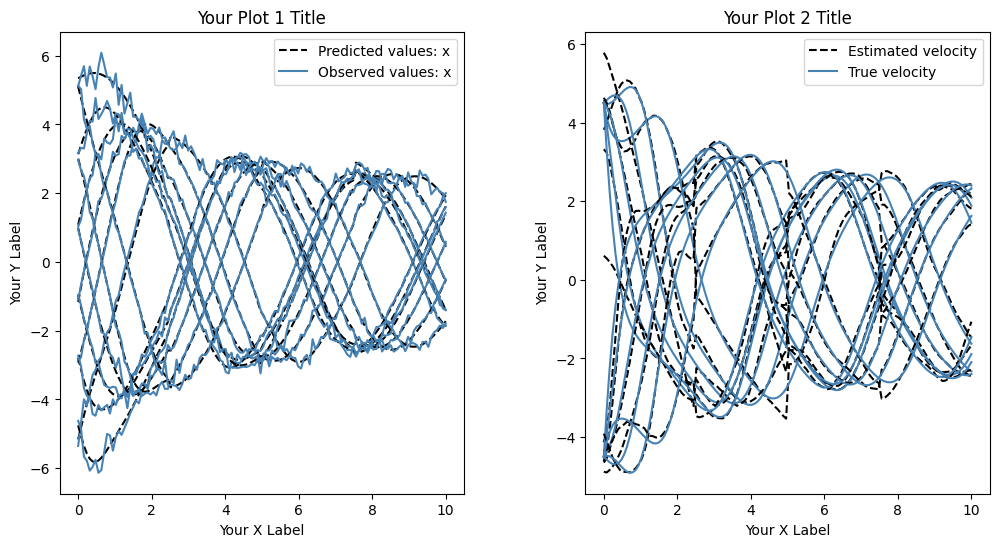

In [ ]:
import matplotlib.pyplot as plt

N=12                 

fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(1, 2, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(ts[0].flatten(), prediction_x[0].flatten(), label="Predicted values: x",  c="black", linestyle="dashed")
ax1.plot(ts[0].flatten(), (observed_x*random_factor)[0].flatten(), label="Observed values: x", c="steelblue")
for i in range(1,N):
    ax1.plot(ts[0].flatten(), prediction_x[i].flatten(),  c="black", linestyle="dashed")
    ax1.plot(ts[0].flatten(), (observed_x*random_factor)[i].flatten(), c="steelblue")
ax1.set_title("Position over time")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("x")
ax1.legend()
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(ts[0].flatten(), prediction_v[0], label="Estimated velocity", c="black", linestyle="dashed")
ax2.plot(ts[0].flatten(), observed_v[0].flatten(),label="True velocity", c="steelblue")
for i in range(1,N):
    ax2.plot(ts[0].flatten(), prediction_v[i], c="black", linestyle="dashed")
    ax2.plot(ts[0].flatten(), observed_v[i].flatten(), c="steelblue")
ax2.set_title("Velocity over time")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("x'")
ax2.legend()
plt.show()




Play around with $N\in \{1,\dots,12\}$ to display more paths corresponding to different initial conditions!

We can now recreate some of the plots from the paper displaying the phase portraits of both Van der Pol systems and our predicted ODE approximations:

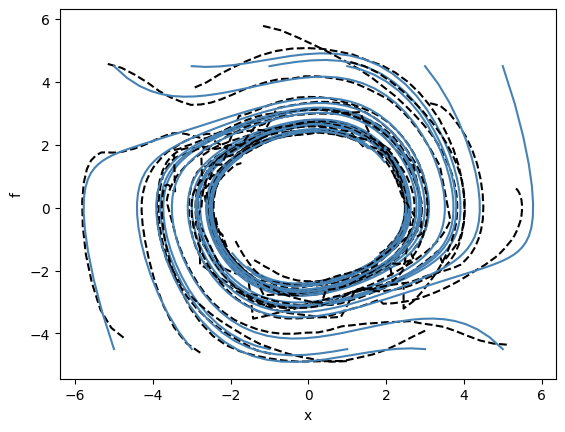

In [154]:
for i in range(12):
    plt.plot(prediction_x[i], prediction_v[i],  c="black",linestyle="dashed")
    plt.plot(observed_x[i].flatten(), observed_v[i].flatten(), c="steelblue")
    plt.xlabel("x")
    plt.ylabel("f")

Next we load a discretization of the more complicated Rössler attractor, which was discretized at a much higher temporal resolution, hinting that we also need to increase the number of windows
used to estimate the underlying ODE. We therefore, in accordance with the paper, analyze the data using 32 windows instead of the previous 4 even though the total time for which the systems were simulated is the same! The corresponding ODE is given by 
```{math}
\begin{align}
dx &= -5(y+z)\\
dy &= (0.2y+x)\\
dz &= 5(0.2+z (-5.7+x))
\end{align}
```
and we will focus on the first dimension $x$.

In [155]:
data = load_dataset("FIM4Science/roessler-example", download_mode="force_redownload", name="default")["train"] 
data.set_format("torch")
ts=data["t"][:].reshape(1,4096,1)
observed_x=data["x"][:].reshape(1,4096,1)*(1+torch.normal(0,0.05,size=(1,4096,1)))
observed_v=data["x_prime"][:].reshape(1,4096,1)

data/train-00000-of-00001.parquet:   0%|          | 0.00/230k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4096 [00:00<?, ? examples/s]

In [156]:
mask = torch.ones_like(ts)*0.5
mask = torch.bernoulli(mask).type(torch.bool)
batch_x=prepare_data_base(ts,observed_x,mask=mask,num_windows=32)
base_model.eval()
with torch.no_grad():
    rtn=base_model(batch_x)
    prediction_x = rtn["visualizations"]["solution"]["learnt"]
    prediction_v = rtn["visualizations"]["drift"]["learnt"]

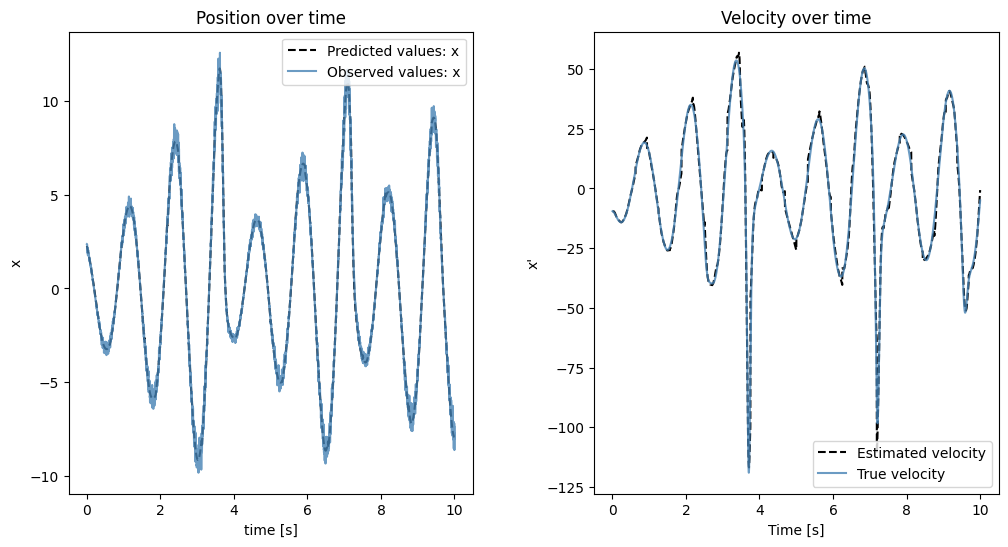

In [ ]:
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(1, 2, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(ts.flatten(), prediction_x.flatten(), label="Predicted values: x",  c="black", linestyle="dashed")
ax1.plot(ts.flatten(), (observed_x).flatten(), label="Observed values: x", c="steelblue",alpha=0.8)

ax1.set_title("Position over time")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("x")
ax1.legend()
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(ts.flatten(), prediction_v.flatten(), label="Estimated velocity", c="black", linestyle="dashed")
ax2.plot(ts.flatten(), observed_v.flatten(),label="True velocity", c="steelblue",alpha=0.8)
ax2.set_title("Velocity over time")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("x'")
ax2.legend()
plt.show()

Next we will see how to use the \texttt{FIM} model to solve temporal missing patterns!